## Example: Self-renormalization of Pion PDF

- Reference: https://arxiv.org/pdf/2103.02965

- Using multi-lattice-spacing data to extract linear divergence, discretization error together with the resummed log divergence;

- Match the perturbative PDF in MS-bar scheme to extract renormalization factor.

- All processes can be done in one class: Self_Renorm, see the end of the notebook.

- This example uses the fake data generated randomly.

In [11]:
import numpy as np
import gvar as gv
import pandas as pd
import matplotlib.pyplot as plt
import lsqfit as lsf

from lametlat.renormalization.self_renormalization import *
from lametlat.utils.plot_settings import *
from lametlat.utils.constants import GEV_FM

### Read Data

In [12]:
# Read data file, skipping blank rows and selecting specific columns
datafile = "data/Pion_PDF_fake.txt"
raw_data = pd.read_csv(datafile, sep="\s+", header=0, skipinitialspace=True, skip_blank_lines=True)

# Rename columns for clarity
raw_data.columns = ['z_over_a', 'a', 'mean', 'err']

# Convert z/a to z in fm
raw_data['z'] = raw_data['z_over_a'] * raw_data['a']

# Display the first few rows to verify the data
print(raw_data.head())

   z_over_a       a     mean       err       z
0         0  0.1213  1.05983  0.004531  0.0000
1         1  0.1213  1.00205  0.004283  0.1213
2         2  0.1213  0.86991  0.003725  0.2426
3         3  0.1213  0.70812  0.003057  0.3639
4         4  0.1213  0.55147  0.002425  0.4852


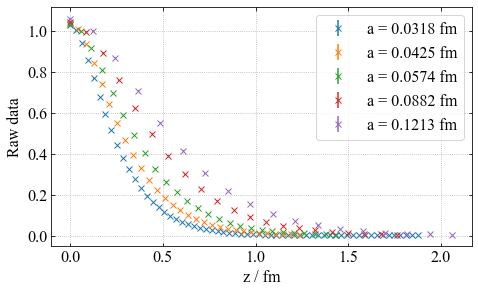


Raw data for a = 0.0318 fm:
    z_over_a       a     mean       err       z
95         0  0.0318  1.03073  0.000865  0.0000
96         1  0.0318  1.00359  0.000841  0.0318
97         2  0.0318  0.94175  0.000789  0.0636
98         3  0.0318  0.85838  0.000717  0.0954
99         4  0.0318  0.76820  0.000643  0.1272

Raw data for a = 0.0425 fm:
    z_over_a       a     mean       err       z
65         0  0.0425  1.03929  0.001529  0.0000
66         1  0.0425  1.00839  0.001479  0.0425
67         2  0.0425  0.93787  0.001373  0.0850
68         3  0.0425  0.84370  0.001227  0.1275
69         4  0.0425  0.74293  0.001077  0.1700

Raw data for a = 0.0574 fm:
    z_over_a       a     mean       err       z
39         0  0.0574  1.03359  0.001611  0.0000
40         1  0.0574  0.99813  0.001553  0.0574
41         2  0.0574  0.91702  0.001425  0.1148
42         3  0.0574  0.81021  0.001255  0.1722
43         4  0.0574  0.69764  0.001083  0.2296

Raw data for a = 0.0882 fm:
    z_over_a       a

In [13]:
# Group data by lattice spacing
grouped_data = raw_data.groupby('a')

# Create a plot to visualize the raw data
fig, ax = default_plot()

for name, group in grouped_data:
    plt.errorbar(group['z'], group['mean'], yerr=group['err'], fmt='x', label=f'a = {name:.4f} fm')

plt.xlabel('z / fm', **fs_p)
plt.ylabel('Raw data', **fs_p)
plt.legend(loc="upper right", **fs_p)
plt.tight_layout()
plt.show()

# Print the first few rows of raw data for each lattice spacing
for name, group in grouped_data:
    print(f"\nRaw data for a = {name:.4f} fm:")
    print(group.head())



### Plot log(h(z, a)) v.s. 1/a

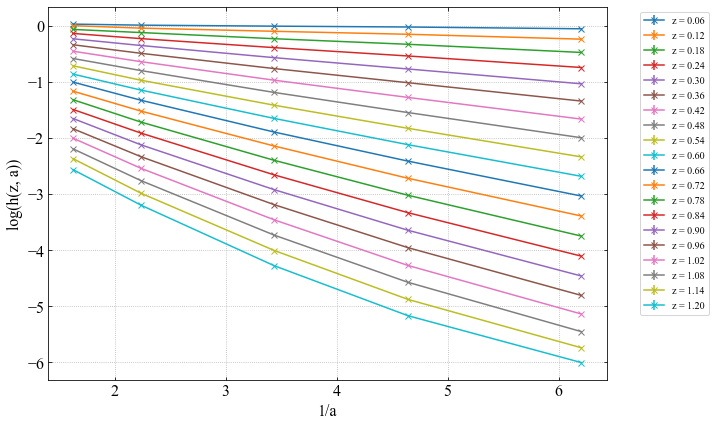

Lattice spacing: 0.0318 fm
1/a: 6.2053 GeV
First 5 rows:
z: 0.0600, log_mean: -0.0526, log_err: 0.0008
z: 0.1200, log_mean: -0.2375, log_err: 0.0008
z: 0.1800, log_mean: -0.4743, log_err: 0.0008
z: 0.2400, log_mean: -0.7428, log_err: 0.0009
z: 0.3000, log_mean: -1.0335, log_err: 0.0009


Lattice spacing: 0.0425 fm
1/a: 4.6430 GeV
First 5 rows:
z: 0.0600, log_mean: -0.0209, log_err: 0.0015
z: 0.1200, log_mean: -0.1505, log_err: 0.0015
z: 0.1800, log_mean: -0.3290, log_err: 0.0014
z: 0.2400, log_mean: -0.5374, log_err: 0.0015
z: 0.3000, log_mean: -0.7692, log_err: 0.0015


Lattice spacing: 0.0574 fm
1/a: 3.4378 GeV
First 5 rows:
z: 0.0600, log_mean: -0.0056, log_err: 0.0016
z: 0.1200, log_mean: -0.0972, log_err: 0.0016
z: 0.1800, log_mean: -0.2295, log_err: 0.0015
z: 0.2400, log_mean: -0.3886, log_err: 0.0016
z: 0.3000, log_mean: -0.5674, log_err: 0.0016




In [14]:
# Interpolate data for all lattice spacings on a z list

# Create a z list for interpolation
z_interp = np.arange(0.06, 1.26, 0.06)

# Initialize a dictionary to store interpolated data
interpolated_data = {}

# Interpolate data for each lattice spacing
for name, group in grouped_data:
    # Interpolate mean values using np.interp
    interpolated_mean = np.interp(z_interp, group['z'], group['mean'], left=np.nan, right=np.nan)
    
    # Interpolate error values using np.interp
    interpolated_err = np.interp(z_interp, group['z'], group['err'], left=np.nan, right=np.nan)
    
    # Store interpolated data
    interpolated_data[name] = {'z': z_interp, '1/a': GEV_FM / float(name), 'mean': interpolated_mean, 'err': interpolated_err} # Add a new column '1/a' in GeV

# Create a new dictionary to store the log of interpolated data
log_interpolated_data = {}

for name, data in interpolated_data.items():
    # Combine mean and err into gvar objects
    gvar_data = gv.gvar(data['mean'], data['err'])
    
    # Take the log of the gvar objects
    log_gvar_data = gv.log(gvar_data)
    
    # Store the results in the new dictionary
    log_interpolated_data[name] = {
        'z': data['z'],
        '1/a': data['1/a'],
        'log_mean': gv.mean(log_gvar_data),
        'log_err': gv.sdev(log_gvar_data)
    }

# Prepare data for plotting
a_inv_values = [log_interpolated_data[name]['1/a'] for name in log_interpolated_data]

plt.figure(figsize=(10, 6))

for z_idx, z in enumerate(z_interp):
    means = [log_interpolated_data[name]['log_mean'][z_idx] for name in log_interpolated_data]
    errors = [log_interpolated_data[name]['log_err'][z_idx] for name in log_interpolated_data]
    
    plt.errorbar(a_inv_values, means, yerr=errors, fmt='x-', label=f'z = {z:.2f}')

plt.xlabel('1/a', **fs_p)
plt.ylabel('log(h(z, a))', **fs_p)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.tick_params(direction="in", top="on", right="on", **ls_p)
plt.grid(linestyle=":")
plt.show()

# Print the first few rows of log_interpolated_data
for name, data in list(log_interpolated_data.items())[:3]:  # Limit to first 3 items
    print(f"Lattice spacing: {name} fm")
    print(f"1/a: {data['1/a']:.4f} GeV")
    print("First 5 rows:")
    for i in range(5):  # Print first 5 rows
        print(f"z: {data['z'][i]:.4f}, log_mean: {data['log_mean'][i]:.4f}, log_err: {data['log_err'][i]:.4f}")
    print("\n")


### Fit a-dependence to get g and f

In [15]:
# Fit a dependence of log(h(z, a)) on each z

mu = 2.0  # GeV

priors = gv.BufferDict()
priors['g'] = gv.gvar(0, 20)
priors['f'] = gv.gvar(0, 5)

fit_res_ls = []
for z_idx, z in enumerate(z_interp):
    a_ls = []
    log_gvar_data = []
    for name, data in log_interpolated_data.items():
        temp = gv.gvar(data['log_mean'][z_idx], data['log_err'][z_idx])
        a_ls.append(float(name))  # Convert string to float
        log_gvar_data.append(temp)

    a_array = np.array(a_ls)

    fcn = bare_pdf_a_dep_fcn(z, mu)

    try:
        fit_res = lsf.nonlinear_fit(data=(a_array, log_gvar_data), fcn=fcn, prior=priors, maxit=10000, svdcut=1e-100, fitter='scipy_least_squares')
        print(f"Fit results: p_val = {fit_res.Q}, g = {fit_res.p['g']}, f = {fit_res.p['f']}")
    except Exception as e:
        print(f"Error during fitting: {str(e)}")

    fit_res_ls.append(fit_res)
    print("\n")

Fit results: p_val = 2.148980214082997e-06, g = 0.0651(17), f = 0.1126(76)


Fit results: p_val = 8.680439201641219e-14, g = 0.1911(17), f = 0.0398(76)


Fit results: p_val = 5.426779065076098e-10, g = 0.2570(17), f = 0.0217(76)


Fit results: p_val = 3.9337157041436793e-10, g = 0.2836(17), f = 0.0481(76)


Fit results: p_val = 2.0386391867370414e-06, g = 0.2866(18), f = 0.0831(78)


Fit results: p_val = 0.0002893590799338501, g = 0.2713(19), f = 0.1292(80)


Fit results: p_val = 0.014735172406834215, g = 0.2396(21), f = 0.1859(83)


Fit results: p_val = 0.34369856482213273, g = 0.1987(23), f = 0.2376(88)


Fit results: p_val = 0.4640602868665302, g = 0.1463(25), f = 0.2987(93)


Fit results: p_val = 0.1502686891473502, g = 0.0912(28), f = 0.3401(99)


Fit results: p_val = 0.017510462240983554, g = 0.0272(31), f = 0.398(11)


Fit results: p_val = 6.516261873855801e-05, g = -0.0384(35), f = 0.431(11)


Fit results: p_val = 1.4675846861864473e-07, g = -0.1098(39), f = 0.482(12)


Fit res

### Plot fit results on top of the data

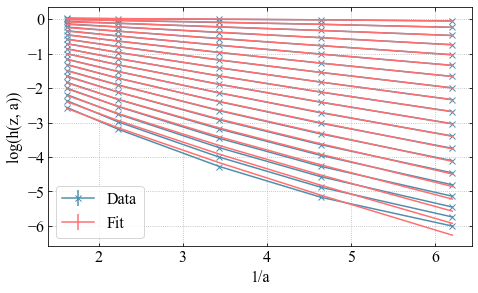

In [16]:
# Plot fit results together with the log data for comparison

fig, ax = default_plot()

# Plot the log data points
for z_idx, z in enumerate(z_interp):
    means = [log_interpolated_data[name]['log_mean'][z_idx] for name in log_interpolated_data]
    errors = [log_interpolated_data[name]['log_err'][z_idx] for name in log_interpolated_data]
    
    plt.errorbar(a_inv_values, means, yerr=errors, fmt='x-', color=blue, label='Data' if z_idx == 0 else '')

# Plot the fit results
for z_idx, z in enumerate(z_interp):
    fcn = bare_pdf_a_dep_fcn(z, mu)
    fit_res = fit_res_ls[z_idx]

    a_values = GEV_FM / np.array(a_inv_values)

    fit_vals = [fcn(a, fit_res.p) for a in a_values]
    plt.errorbar(a_inv_values, gv.mean(fit_vals), yerr=gv.sdev(fit_vals), fmt='-', color=red, label='Fit' if z_idx == 0 else '')

plt.xlabel('1/a', **fs_p)
plt.ylabel('log(h(z, a))', **fs_p)
plt.legend(**fs_p)
plt.tight_layout()
plt.show()


### Comparing with MS-bar to fit m0

- Z_MS_bar = exp( g - m0 * z )

- m0 * z = g - log(Z_MS_bar)

Least Square Fit:
  chi2/dof [dof] = 0.6 [3]    Q = 0.61    logGBF = 1.3937

Parameters:
             m0   0.0201 (40)     [  0.0 (1.0) ]  
              b   0.0197 (26)     [  0.0 (5.0) ]  

Settings:
  svdcut/n = 1e-100/0    tol = (1e-08,1e-10*,1e-10)    (itns/time = 2/0.0)
  fitter = scipy_least_squares    method = trf



/var/folders/4k/g6g3xcl141552ptd6rnzqgth0000gn/T/ipykernel_17527/3843239119.py:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "x-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(z_array, gv.mean(m0z_array), yerr=gv.sdev(m0z_array), fmt='x-', label='m0 * z', **errorb)


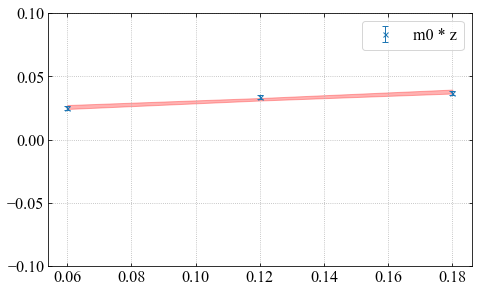

/var/folders/4k/g6g3xcl141552ptd6rnzqgth0000gn/T/ipykernel_17527/3843239119.py:35: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(z_interp, gv.mean(f_ls), yerr=gv.sdev(f_ls), fmt='o-', label='f(z)', **errorb)


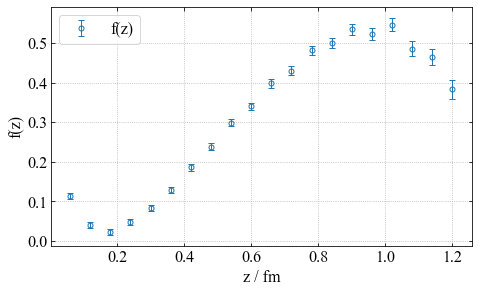

In [17]:
# Extract g(z) and f(z) from the fit results

g_ls = []
f_ls = []
ms_bar_ls = []
for z_idx, z in enumerate(z_interp):
    g_ls.append(fit_res_ls[z_idx].p['g'])
    f_ls.append(fit_res_ls[z_idx].p['f'])   
    ms_bar_ls.append(pdf_ms_bar(z, mu))

max_z_idx = 3

# Select the first 4 z values for perturbation theory
z_array = z_interp[:max_z_idx]
g_array = np.array(g_ls[:max_z_idx])
ms_bar_array = np.array(ms_bar_ls[:max_z_idx])

# Fit m0 to the data
m0z_array = g_array - np.log(ms_bar_array)
m0_fit_res = fit_m0(z_array, g_array)
print(m0_fit_res)
m0z_fit = m0_fit_res.p['m0'] * z_array / GEV_FM + m0_fit_res.p['b']

# Plot the results
fig, ax = default_plot()
ax.errorbar(z_array, gv.mean(m0z_array), yerr=gv.sdev(m0z_array), fmt='x-', label='m0 * z', **errorb)
ax.fill_between(z_array, gv.mean(m0z_fit)+gv.sdev(m0z_fit), gv.mean(m0z_fit)-gv.sdev(m0z_fit), color='r', alpha=0.3)
ax.set_ylim(-0.1, 0.1)
plt.legend(**fs_p)
plt.tight_layout()
plt.show()

# Plot the f(z) to check the linearity
fig, ax = default_plot()
ax.errorbar(z_interp, gv.mean(f_ls), yerr=gv.sdev(f_ls), fmt='o-', label='f(z)', **errorb)
ax.set_xlabel('z / fm', **fs_p)
ax.set_ylabel('f(z)', **fs_p)
ax.legend(**fs_p)
plt.tight_layout()
plt.show()


### Plot to check consistency with MS-bar

/var/folders/4k/g6g3xcl141552ptd6rnzqgth0000gn/T/ipykernel_17527/345450623.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "x-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(z_interp, gv.mean(renorm_pdf), yerr=gv.sdev(renorm_pdf),
/var/folders/4k/g6g3xcl141552ptd6rnzqgth0000gn/T/ipykernel_17527/345450623.py:18: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(z_interp, gv.mean(renorm_pdf / ms_bar_pdf), yerr=gv.sdev(renorm_pdf / ms_bar_pdf),


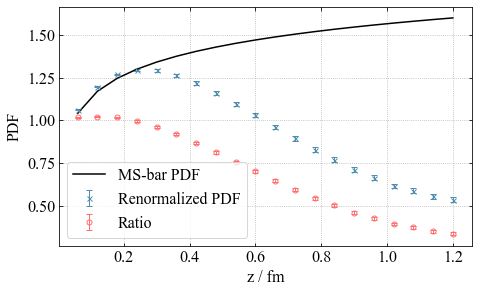

[1.0189(28) 1.0218(30) 1.0189(28) 0.9972(51) 0.9631(61) 0.9195(69)
 0.8672(76) 0.8130(81) 0.7552(85) 0.7009(87) 0.6456(88) 0.5945(89)
 0.5447(88) 0.5015(88) 0.4598(87) 0.4267(86) 0.3926(85) 0.3721(86)
 0.3492(86) 0.3346(89)]


In [18]:
# renormalized PDF = exp( g - m0 * z )
renorm_pdf = np.exp( np.array(g_ls) - m0_fit_res.p['m0'] * z_interp / GEV_FM )

# Calculate MS-bar PDF for all z values
ms_bar_pdf = np.array([pdf_ms_bar(z, mu) for z in z_interp])

# Create the plot
fig, ax = default_plot()

# Plot renormalized PDF
ax.errorbar(z_interp, gv.mean(renorm_pdf), yerr=gv.sdev(renorm_pdf), 
            fmt='x-', label='Renormalized PDF', color=blue, **errorb)

# Plot MS-bar PDF
ax.plot(z_interp, ms_bar_pdf, 'k', label='MS-bar PDF')

# Plot ratio between renormalized and MS-bar PDF
ax.errorbar(z_interp, gv.mean(renorm_pdf / ms_bar_pdf), yerr=gv.sdev(renorm_pdf / ms_bar_pdf), 
            fmt='o-', color=red, label='Ratio', **errorb)

ax.set_xlabel('z / fm', **fs_p)
ax.set_ylabel('PDF', **fs_p)
ax.legend(**fs_p)

plt.tight_layout()
plt.show()

print(renorm_pdf / ms_bar_pdf)


### Extract renormalization factor Z_R

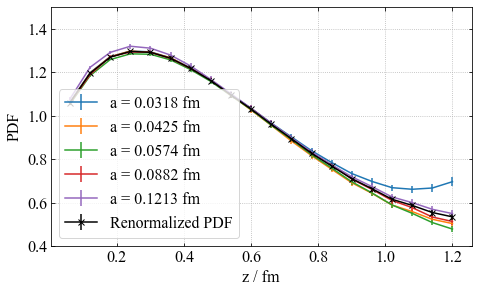

In [19]:
# Collect all Z_R in to a dictionary, and use it to renormalize the interpolated data
Z_R_dict = {}
renorm_data = {}

for name, data in interpolated_data.items():
    a = float(name)
    zr = renormalization_factor(data['z'], a, np.array(f_ls), m0_fit_res.p['m0'])
    Z_R_dict[a] = zr
    renorm_data[a] = gv.gvar(data['mean'], data['err']) / zr
    
# Plot all renormalized data together with the renorm_PDF
fig, ax = default_plot()
for a in Z_R_dict:
    ax.errorbar(z_interp, gv.mean(renorm_data[a]), yerr=gv.sdev(renorm_data[a]), fmt='-', label=f'a = {a:.4f} fm')
ax.errorbar(z_interp, gv.mean(renorm_pdf), yerr=gv.sdev(renorm_pdf), fmt='x-', color='k', label='Renormalized PDF')
ax.set_xlabel('z / fm', **fs_p)
ax.set_ylabel('PDF', **fs_p)
ax.legend(**fs_p)
plt.ylim(0.4, 1.5)
plt.tight_layout()
plt.show()

### Use the class to do the self-renormalization

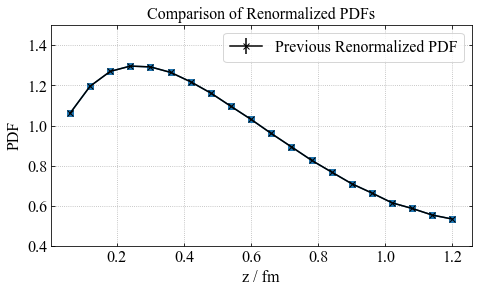

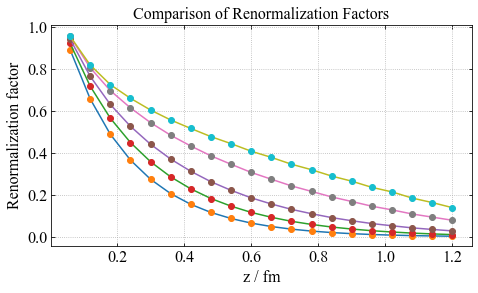

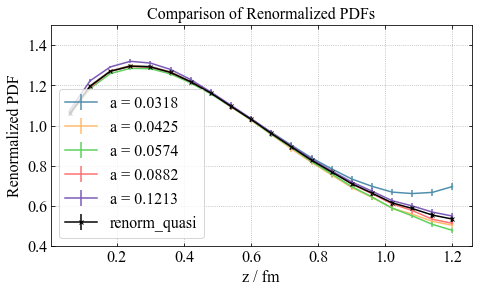

In [20]:
# Import the SELF_RENORM class
from lametlat.renormalization.self_renormalization import SELF_RENORM

quasi_data = {}
for name, data in interpolated_data.items():
    quasi_data[name] = gv.gvar(data['mean'], data['err'])

# Initialize the SELF_RENORM object
self_renorm = SELF_RENORM(bare_quasi=quasi_data, z_interp=z_interp, mu=2.0)

# Run the self-renormalization procedure
renorm_quasi, zr_dict = self_renorm.main()

# Plot the results
fig, ax = default_plot()

ax.errorbar(z_interp, gv.mean(renorm_quasi), yerr=gv.sdev(renorm_quasi), fmt='s-')
ax.errorbar(z_interp, gv.mean(renorm_pdf), yerr=gv.sdev(renorm_pdf), fmt='x-', color='k', label='Previous Renormalized PDF')

ax.set_xlabel('z / fm', **fs_p)
ax.set_ylabel('PDF', **fs_p)
ax.legend(**fs_p)
ax.set_ylim(0.4, 1.5)

plt.title('Comparison of Renormalized PDFs', **fs_p)
plt.tight_layout()
plt.show()

# Compare zr_dict with Z_R_dict
fig, ax = default_plot()

for a in Z_R_dict:
    ax.errorbar(z_interp, gv.mean(Z_R_dict[a]), yerr=gv.sdev(Z_R_dict[a]), fmt='-')
    ax.errorbar(z_interp, gv.mean(zr_dict[a]), yerr=gv.sdev(zr_dict[a]), fmt='o')

ax.set_xlabel('z / fm', **fs_p)
ax.set_ylabel('Renormalization factor', **fs_p)
plt.title('Comparison of Renormalization Factors', **fs_p)
plt.tight_layout()
plt.show()


# Renormalize quasi_data using zr_dict
renormalized_data = {}
for a, data in quasi_data.items():
    renormalized_data[a] = data / zr_dict[a]

# Plot the renormalized results and compare with renorm_quasi
fig, ax = default_plot()

# Plot renormalized data for each lattice spacing
colors = ['red', 'blue', 'green', 'orange']
for i, (a, data) in enumerate(renormalized_data.items()):
    ax.errorbar(z_interp, gv.mean(data), yerr=gv.sdev(data), 
                fmt='-', color=color_ls[i], label=f'a = {a}', markersize=4)
    
# Plot renorm_quasi
ax.errorbar(z_interp, gv.mean(renorm_quasi), yerr=gv.sdev(renorm_quasi), 
            fmt='x-', color='black', label='renorm_quasi', markersize=4)

ax.set_xlabel('z / fm', **fs_p)
ax.set_ylabel('Renormalized PDF', **fs_p)
ax.legend(**fs_p)
ax.set_ylim(0.4, 1.5)

plt.title('Comparison of Renormalized PDFs', **fs_p)
plt.tight_layout()
plt.show()



